In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

### Graph theory function

In [2]:
import networkx as nx

def depth_of_node(G, node):
    # Find the shortest path from the root to the given node to calculate depth
    # Assuming there's a single root node, the one without any predecessors
    try:
        root = [n for n in G.nodes if G.out_degree(n) == 0][0]  # find the root
        depth = nx.shortest_path_length(G, source=node, target=root)
    except (nx.NetworkXNoPath, IndexError):
        # Handle the case where there's no root or no path exists
        return None
    return depth

def deepest_shared_ancestor_depth(G, node1, node2):
    descendants1 = nx.descendants(G, node1) | {node1}
    descendants2 = nx.descendants(G, node2) | {node2}
    # Find common ancestors
    common_ancestors = descendants1.intersection(descendants2)
    if not common_ancestors:
        return None  # No shared ancestor
    # Get the depth of each common ancestor
    ancestor_depths = {ancestor: depth_of_node(G, ancestor) for ancestor in common_ancestors}
    # Find the ancestor with the maximum depth
    deepest_ancestor = max(ancestor_depths, key=ancestor_depths.get)
    return ancestor_depths[deepest_ancestor]


In [3]:
def compute_deep_shared_ancestor_matrix(graph):
    leaf_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'leaf']
    sim_matrix = torch.zeros((len(leaf_nodes), len(leaf_nodes)))
    dsa_matrix = torch.zeros((len(leaf_nodes), len(leaf_nodes)))
    for i1, nd in enumerate(leaf_nodes):
        d1 = depth_of_node(graph, nd)
        for i2, nd2 in enumerate(leaf_nodes):
            d2 = depth_of_node(graph, nd2)
            dsa = deepest_shared_ancestor_depth(graph, nd, nd2)
            dsa_matrix[i1, i2] = dsa
            sim_matrix[i1, i2] = 2 * dsa / (d1 + d2)
    return dsa_matrix, sim_matrix

In [4]:

def visulize_computational_graph(graph):
    pos = nx.spring_layout(graph)
    labels = {node: data['name'] for node, data in graph.nodes(data=True)}

    # Separate nodes by type
    leaf_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'leaf']
    function_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'function']
    # Draw function nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=function_nodes, node_color='lightblue', node_shape='o', node_size=500)
    # Draw leaf nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=leaf_nodes, node_color='lightgreen', node_shape='s', node_size=500)

    # Draw edges and labels
    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='-|>',)
    nx.draw_networkx_labels(graph, pos, labels=labels)

    plt.title("Computation Graph with Leaf Nodes Annotated")
    plt.axis('off')
    plt.show()


### Forward tracing

https://pytorch.org/tutorials/intermediate/torch_export_tutorial.html

In [5]:
import torch
from torch.fx import symbolic_trace
import networkx as nx

def export_module2nxGraph(exported_mod):
    # Obtain the module from the exported model
    exported_module = exported_mod.module()
    # Use torch.fx to trace the module and get the computational graph
    traced_module = symbolic_trace(exported_module)
    graph = traced_module.graph
    # Initialize a NetworkX directed graph
    G = nx.DiGraph()
    # Add nodes and edges to the NetworkX graph based on the torch.fx graph
    for node in graph.nodes:
        G.add_node(node.name, op=node.op, target=str(node.target), name=node.name, 
                type='leaf' if node.op == 'placeholder' else 'function')

        for arg in node.all_input_nodes:
            G.add_edge(arg.name, node.name)
    return G


def fx_extract_graph(func, ):
    # Use torch.fx to trace the function and get the computational graph
    traced_func = symbolic_trace(func)
    graph = traced_func.graph
    # Initialize a NetworkX directed graph
    G = nx.DiGraph()
    # Add nodes and edges to the NetworkX graph based on the torch.fx graph
    for node in graph.nodes:
        G.add_node(node.name, op=node.op, target=str(node.target), name=node.name, 
                type='leaf' if node.op == 'placeholder' else 'function')

        for arg in node.all_input_nodes:
            G.add_edge(arg.name, node.name)
    return G

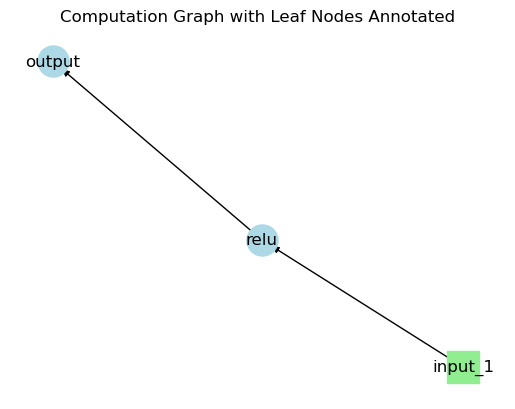

In [6]:
func = torch.nn.ReLU()
G = fx_extract_graph(func, )
visulize_computational_graph(G)

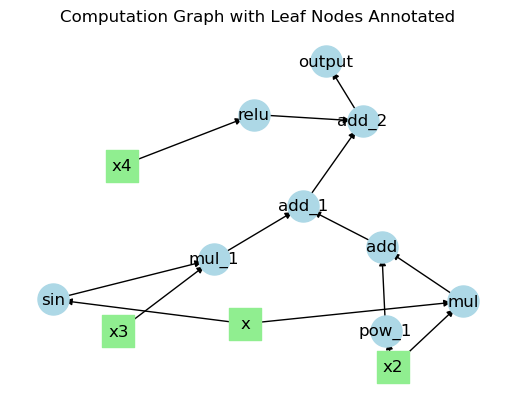

Shared Ancestor Similarity Matrix:
tensor([[1.0000, 0.8000, 0.6667, 0.2500],
        [0.8000, 1.0000, 0.4444, 0.2500],
        [0.6667, 0.4444, 1.0000, 0.2857],
        [0.2500, 0.2500, 0.2857, 1.0000]])


In [7]:
func = lambda x, x2, x3, x4: x * x2 + x2 ** 2 + x3 * torch.sin(x) + torch.relu(x4)
G = fx_extract_graph(func)
visulize_computational_graph(G)
dsa_matrix, sim_matrix = compute_deep_shared_ancestor_matrix(G)
print("Shared Ancestor Similarity Matrix:")
print(sim_matrix)

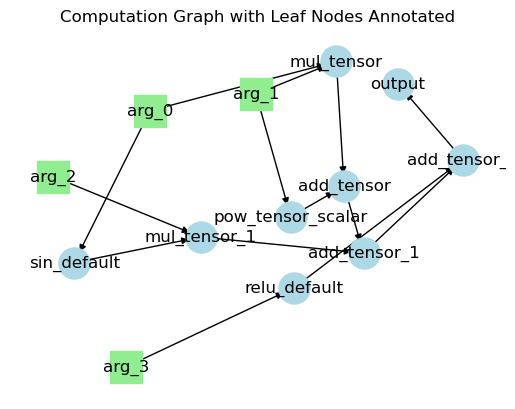

Shared Ancestor Similarity Matrix:
tensor([[1.0000, 0.8000, 0.6667, 0.2500],
        [0.8000, 1.0000, 0.4444, 0.2500],
        [0.6667, 0.4444, 1.0000, 0.2857],
        [0.2500, 0.2500, 0.2857, 1.0000]])


In [8]:
class MyModule(torch.nn.Module):
    def forward(self, x, x2, x3, x4):
        return x * x2 + x2 ** 2 + x3 * torch.sin(x) + torch.relu(x4)
    

x = torch.tensor([1.0], requires_grad=True)
x2 = torch.tensor([2.0], requires_grad=True)
x3 = torch.tensor([3.0], requires_grad=True)
x4 = torch.tensor([4.0], requires_grad=True)
exported_fun = torch.export.export(MyModule(), (x, x2, x3, x4), )
G = export_module2nxGraph(exported_fun)
visulize_computational_graph(G)
dsa_matrix, sim_matrix = compute_deep_shared_ancestor_matrix(G)
print("Shared Ancestor Similarity Matrix:")
print(sim_matrix)

In [ ]:
print(exported_fun.graph)

graph():
    %arg0_1 : [num_users=2] = placeholder[target=arg0_1]
    %arg1_1 : [num_users=2] = placeholder[target=arg1_1]
    %arg2_1 : [num_users=1] = placeholder[target=arg2_1]
    %arg3_1 : [num_users=1] = placeholder[target=arg3_1]
    %mul : [num_users=1] = call_function[target=torch.ops.aten.mul.Tensor](args = (%arg0_1, %arg1_1), kwargs = {})
    %pow_1 : [num_users=1] = call_function[target=torch.ops.aten.pow.Tensor_Scalar](args = (%arg1_1, 2), kwargs = {})
    %add : [num_users=1] = call_function[target=torch.ops.aten.add.Tensor](args = (%mul, %pow_1), kwargs = {})
    %sin : [num_users=1] = call_function[target=torch.ops.aten.sin.default](args = (%arg0_1,), kwargs = {})
    %mul_1 : [num_users=1] = call_function[target=torch.ops.aten.mul.Tensor](args = (%arg2_1, %sin), kwargs = {})
    %add_1 : [num_users=1] = call_function[target=torch.ops.aten.add.Tensor](args = (%add, %mul_1), kwargs = {})
    %relu : [num_users=1] = call_function[target=torch.ops.aten.relu.default](args =

In [9]:
exported_fun.graph.nodes

In [10]:
import torch
from torch.fx import symbolic_trace
import networkx as nx

class MyModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(100, 10)

    def forward(self, x, y):
        return torch.nn.functional.relu(self.lin(x + y), inplace=True)

# Instantiate your model
mod = MyModule()

# Export the model (as you did)
exported_mod = torch.export.export(mod, (torch.randn(8, 100), torch.randn(8, 100)))

# Obtain the module from the exported model
exported_module = exported_mod.module()

# Use torch.fx to trace the module and get the computational graph
traced_module = symbolic_trace(exported_module)
graph = traced_module.graph

# Initialize a NetworkX directed graph
G = nx.DiGraph()

# Add nodes and edges to the NetworkX graph based on the torch.fx graph
for node in graph.nodes:
    G.add_node(node.name, op=node.op, target=str(node.target), name=node.name, 
               type='leaf' if node.op == 'placeholder' else 'function')

    for arg in node.all_input_nodes:
        G.add_edge(arg.name, node.name)

# Now, G is your computational graph in NetworkX
# You can visualize it or analyze it as needed
print("Nodes in the NetworkX graph:")
print(G.nodes(data=True))

print("\nEdges in the NetworkX graph:")
print(list(G.edges()))

Nodes in the NetworkX graph:
[('arg_0', {'op': 'placeholder', 'target': 'arg_0', 'name': 'arg_0', 'type': 'leaf'}), ('arg_1', {'op': 'placeholder', 'target': 'arg_1', 'name': 'arg_1', 'type': 'leaf'}), ('lin_weight', {'op': 'get_attr', 'target': 'lin.weight', 'name': 'lin_weight', 'type': 'function'}), ('lin_bias', {'op': 'get_attr', 'target': 'lin.bias', 'name': 'lin_bias', 'type': 'function'}), ('add_tensor', {'op': 'call_function', 'target': 'aten.add.Tensor', 'name': 'add_tensor', 'type': 'function'}), ('t_default', {'op': 'call_function', 'target': 'aten.t.default', 'name': 't_default', 'type': 'function'}), ('addmm_default', {'op': 'call_function', 'target': 'aten.addmm.default', 'name': 'addmm_default', 'type': 'function'}), ('relu_default', {'op': 'call_function', 'target': 'aten.relu.default', 'name': 'relu_default', 'type': 'function'}), ('output', {'op': 'output', 'target': 'output', 'name': 'output', 'type': 'function'})]

Edges in the NetworkX graph:
[('arg_0', 'add_tensor

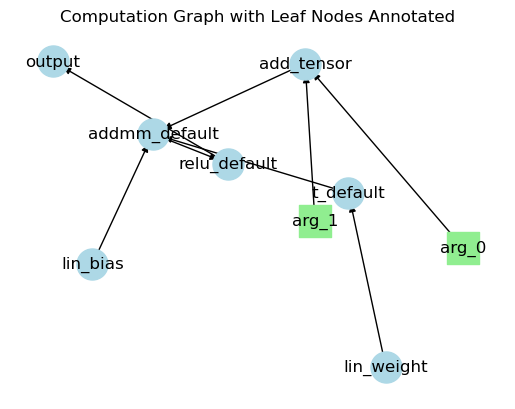

In [11]:
visulize_computational_graph(G)

### Backward tracing

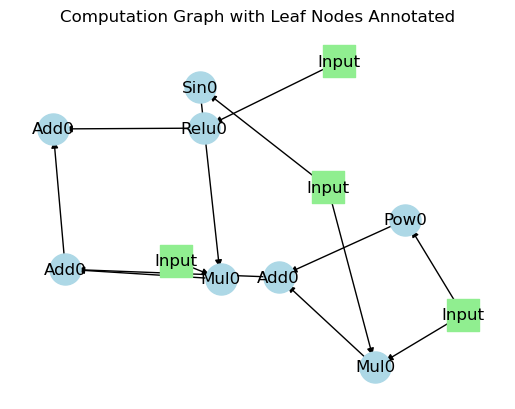

In [73]:


def backward2forward_fun(name):
    """Heuristic function for converting backward function names to forward function names"""
    if name == 'AccumulateGrad':
        return 'Input'
    else:
        return name.replace('Backward', '')


def build_computation_graph(output_tensor):
    graph = nx.DiGraph()
    visited = set()
    def add_nodes(fn):
        if fn in visited or fn is None:
            return
        visited.add(fn)
        # Function node
        node_name = type(fn).__name__
        forward_name = backward2forward_fun(node_name)
        graph.add_node(fn, name=forward_name, type='function')
        # Recursively add previous functions or tensors
        if hasattr(fn, 'next_functions'):
            for idx, (next_fn, _) in enumerate(fn.next_functions):
                if next_fn is not None:
                    graph.add_edge(next_fn, fn)
                    add_nodes(next_fn)
        if hasattr(fn, 'saved_tensors'):
            for t in fn.saved_tensors:
                graph.add_edge(t, fn)
                add_nodes(t)
        if (not hasattr(fn, 'next_functions') and not hasattr(fn, 'saved_tensors')) or \
            (hasattr(fn, 'next_functions') and len(fn.next_functions) == 0) or \
            (hasattr(fn, 'saved_tensors') and len(fn.saved_tensors) == 0):
            # Leaf node
            graph.add_node(fn, name=forward_name, type='leaf')

    # Start traversal from the grad_fn of the output tensor
    add_nodes(output_tensor.grad_fn)
    return graph


# Example usage:
x = torch.tensor([1.0], requires_grad=True)
x2 = torch.tensor([2.0], requires_grad=True)
x3 = torch.tensor([3.0], requires_grad=True)
x4 = torch.tensor([4.0], requires_grad=True)
z = x * x2 + x2 ** 2 + x3 * torch.sin(x) + torch.relu(x4)

graph = build_computation_graph(z)
visulize_computational_graph(graph)

In [72]:
leaf_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'leaf']
dsa_matrix = torch.zeros((len(leaf_nodes), len(leaf_nodes)))
for i1, nd in enumerate(leaf_nodes):
    d1 = depth_of_node(graph, nd)
    for i2, nd2 in enumerate(leaf_nodes):
        d2 = depth_of_node(graph, nd2)
        dsa = deepest_shared_ancestor_depth(graph, nd, nd2)
        dsa_matrix[i1, i2] = 2 * dsa / (d1 + d2)
        # print(nd, nd2, deepest_shared_ancestor_depth(graph, nd, nd2))
print(dsa_matrix)

tensor([[1.0000, 0.7500, 0.5714, 0.0000],
        [0.7500, 1.0000, 0.2857, 0.0000],
        [0.5714, 0.2857, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])


In [ ]:
def visulize_computational_graph(graph):
    pos = nx.spring_layout(graph)
    labels = {node: data['name'] for node, data in graph.nodes(data=True)}

    # Separate nodes by type
    leaf_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'leaf']
    function_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'function']
    # Draw function nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=function_nodes, node_color='lightblue', node_shape='o', node_size=500)
    # Draw leaf nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=leaf_nodes, node_color='lightgreen', node_shape='s', node_size=500)

    # Draw edges and labels
    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='-|>',)
    nx.draw_networkx_labels(graph, pos, labels=labels)

    plt.title("Computation Graph with Leaf Nodes Annotated")
    plt.axis('off')
    plt.show()